# ISeeU: Visually Interpretable ICU Mortality Prediction with ConvNets

In [1]:
import numpy as np
from scipy import stats
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

import itertools
import os

from keras import layers, regularizers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv1D
from keras.layers import AveragePooling2D, MaxPooling2D, MaxPooling1D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping


import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report
from sklearn.utils import resample

import keras.backend as K
K.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model


print(K.tensorflow_backend._get_available_gpus())

%matplotlib inline

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


** First some styling **

In [ ]:
plt.style.use('ggplot')
palette = plt.get_cmap('tab10')

** Define some utility functions **

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',filename=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7,7))
    plt.gca().grid(False)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    
def plot_roc_curve(ground_truth, predictions, filename=None):
    fpr, tpr, thr = roc_curve(y_true=ground_truth, y_score=predictions, drop_intermediate=False)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(15,10))
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    return fpr, tpr, thr

def cross_validation_plot_roc_curve(ground_truth, predictions, filename=None):
    plt.figure(figsize=(15,10))
    i = 0
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for g, p in zip(ground_truth, predictions):
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_true = g, y_score = p, drop_intermediate=False)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.4f)' % (i, roc_auc))
        i += 1
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    #return mean_fpr, mean_tpr
    
def print_classification_report(ground_truth, predictions):
    print(classification_report(ground_truth, predictions, target_names=['die'], labels=[1]))

** Some important values **

In [ ]:
inputs_filename = 'MIMICIII_sapsii_dataset_inputs.pickle'
outputs_filename = 'MIMICIII_sapsii_dataset_mortality_labels.pickle'
split_data = False
model_factories = dict()

## Loading the dataset
Now we will load the dataset, either from Postgres, or from the pickled dataframes

In [ ]:
def load_dataset(inputs_filename, labels_filename):
    if not os.path.exists(inputs_filename):
        user = ''
        host = ''
        dbname = 'mimic'
        schema = 'mimiciii'
        passwd = ''
        con = psycopg2.connect(dbname=dbname, user=user, host=host, 
                           password=passwd)
        cur = con.cursor()
        cur.execute('SET search_path to {}'.format(schema))
        query = '''
        SELECT *, FLOOR(icu_time_hr) AS measurement_hour, 
        CASE WHEN AGE > 80.0 then 80 else AGE end as corrected_age
        FROM mimiciii.datasetsapsii 
        WHERE measurement_name IS NOT NULL AND value IS NOT NULL ORDER BY subject_id
        '''
        data = pd.read_sql_query(query, con)
        data = data[data.measurement_hour != 48]
        print("Number of rows: {0}".format(data.shape[0]))
        #Get ground truth
        mortality_labels = data.drop_duplicates(subset=['subject_id'])[['subject_id','mort_icu']]
        #Sort so it matches the inputs order
        #mortality_labels.sort_values(by='subject_id', inplace=True)
        print("Number of distinct IDs: {0}".format(mortality_labels.shape[0]))
        
        #Pivot data into a stacked PTS representation
        #Any measurements from the same hour will be averaged, except urine output which we'll sum up
        inputs = data.pivot_table(index=['subject_id', 'measurement_name'], 
                                      columns='measurement_hour', values='value', aggfunc=[np.mean, np.sum])
        
        mean_table = inputs['mean']
        sum_table = inputs['sum']
        mean_table[mean_table.index.get_level_values('measurement_name') 
                   == 'URINE'] = sum_table[sum_table.index.get_level_values('measurement_name')
                                           == 'URINE']
        
        inputs = mean_table
                                           
        print("Number of distinct IDs after pivoting: {0}".format(inputs.index.levels[0].shape[0]))
        
        #Add rest of SAPS-II variables - clunky and inefficient but works
        data['measurement_name'] = 'AGE'
        ages = data.pivot_table(index=['subject_id', 'measurement_name'], 
                                          columns='measurement_hour', values='corrected_age', aggfunc=np.mean)\
        .fillna(axis=1, method='bfill').fillna(axis=1, method='ffill')

        data['measurement_name'] = 'SURGICAL'
        surgical = data.pivot_table(index=['subject_id', 'measurement_name'], 
                                          columns='measurement_hour', values='surgical', aggfunc=np.max)\
        .fillna(axis=1, method='bfill').fillna(axis=1, method='ffill')

        data['measurement_name'] = 'ELECTIVE'
        elective = data.pivot_table(index=['subject_id', 'measurement_name'], 
                                          columns='measurement_hour', values='elective', aggfunc=np.max)\
        .fillna(axis=1, method='bfill').fillna(axis=1, method='ffill')

        data['measurement_name'] = 'AIDS'
        aids = data.pivot_table(index=['subject_id', 'measurement_name'], 
                                          columns='measurement_hour', values='aids', aggfunc=np.max)\
        .fillna(axis=1, method='bfill').fillna(axis=1, method='ffill')

        data['measurement_name'] = 'METASTATIC_CANCER'
        metastatic_cancer = data.pivot_table(index=['subject_id', 'measurement_name'], 
                                          columns='measurement_hour', values='metastatic_cancer', aggfunc=np.max)\
        .fillna(axis=1, method='bfill').fillna(axis=1, method='ffill')

        data['measurement_name'] = 'LYMPHOMA'
        lymphoma = data.pivot_table(index=['subject_id', 'measurement_name'], 
                                          columns='measurement_hour', values='lymphoma', aggfunc=np.max)\
        .fillna(axis=1, method='bfill').fillna(axis=1, method='ffill')

        sapsII_inputs = pd.concat([inputs, ages, surgical, elective, aids, metastatic_cancer, lymphoma]).sort_index()
        print("Number of distinct IDs after adding extra variables: {0}".format(sapsII_inputs.index.levels[0].shape[0]))

        #Generate missing series for each patient
        
        index_names = sapsII_inputs.index.names
        new_index = pd.MultiIndex.from_product(sapsII_inputs.index.levels)
        new_index.names = index_names
        sapsII_inputs = sapsII_inputs.reindex(new_index)
        
        print("Number of distinct series after re-indexing: {0}".format(sapsII_inputs.index.levels[1].shape[0]))
        print("Number of distinct hours after re-indexing: {0}".format(sapsII_inputs.shape[1]))
        print("Number of distinct IDs after re-indexing: {0}".format(sapsII_inputs.index.levels[0].shape[0]))
        
        
        
        #Save everything
        sapsII_inputs.to_pickle(inputs_filename)
        mortality_labels.to_pickle(outputs_filename)
        
        con.close()
    else:
        sapsII_inputs = pd.read_pickle(inputs_filename);
        mortality_labels = pd.read_pickle(outputs_filename)
    
    return sapsII_inputs, mortality_labels

In [ ]:
input_dataframe, labels_dataframe = load_dataset(inputs_filename, outputs_filename)

**A sanity check:**

In [7]:
id2 = labels_dataframe['subject_id'].values
id1 = input_dataframe.index.levels[0].values
print(np.setdiff1d(id2,id1))
labels_dataframe.head(10)

[]


,subject_id,mort_icu
0,3,0
842,6,0
1124,9,1
1570,12,0
1965,13,0
2661,17,0
2956,21,0
3274,25,0
3587,26,0
3779,31,1


## Imputation

In [ ]:
#GCS and Fi02 data are imputed to their normal values
#For urine is it better to impute mean, or include an imputation mask
input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSEyes'] = \
    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSEyes'].fillna(method='ffill', axis=1)#.fillna(value=4) 

input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSMotor'] = \
input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSMotor'].fillna(method='ffill', axis=1)#.fillna(value=6)

input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSVerbal'] = \
    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSVerbal'].fillna(method='ffill', axis=1)#.fillna(value=5)

#input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'URINE OUTPUT'] = \
#    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'URINE OUTPUT'].fillna(value=0)

input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'FiO2'] = \
    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'FiO2'].fillna(method='ffill', axis=1).fillna(value=0.2)

input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'PO2'] = \
    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'PO2'].fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)

#Now the rest of NAs are filled
#NOTE: Some NAs will remain, specifically if there is not even one measurement, all values for that particular variable will still be NAs
input_dataframe = input_dataframe.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42)
cv_idx = list(cv.split(X=np.zeros(labels_dataframe.shape[0]), y=labels_dataframe['mort_icu'].values))

Save fold means and deviations to standardize later

In [ ]:
fold_mean = []
fold_std = []

for train, validation in cv_idx:
    fold = input_dataframe.loc[train]
    
    mean = fold.mean(level='measurement_name').mean(axis=1)
    std = fold.std(level='measurement_name').mean(axis=1)
    #Store training fold mean and std to standardize validation folds later
    #Extra dimension is added to make broadcasted division and subtraction possible
    fold_mean.append(mean.values[:, None]) 
    fold_std.append(std.values[:, None])
    

Now, let's shape our data properly

In [12]:
X = input_dataframe.values.reshape([input_dataframe.index.levels[0].shape[0], len(fold_mean[0]), input_dataframe.shape[1]])
y = labels_dataframe.values

#Reshape so each physiological time series 
#becomes a channel (3D) instead of a matrix row (2D)
#X = np.swapaxes(X, 1, 2).reshape((-1, 1, input_dataframe.shape[1], input_dataframe.index.levels[1].shape[0])).astype(np.float32)
X = X.reshape((-1, 1, len(fold_mean[0]), input_dataframe.shape[1])).astype(np.float32)
y = y[:, 1]
y = y[:, None].astype(np.float32)
print("Training inputs shape: {0}".format(X.shape))
print("Training labels shape: {0}".format(y.shape))

Training inputs shape: (22413, 1, 22, 48)
Training labels shape: (22413, 1)


Next, if necessary compute the train/test splits

In [ ]:
if split_data :
    #y = y[:,1]
    #y = y[:,None]
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        stratify=y, random_state=42)
    #X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    print("Number of patients in training: {0}, number of deaths in training: {1}".format(y_train.shape[0], np.sum(y_train)))
    print("Number of patients in test: {0}, number of deaths in test: {1}".format(y_test.shape[0], np.sum(y_test)))
else:
    X_train = X
    y_train = y #Will do Cross-Validation instead

## Convnet 
Now let's define our Keras ConvNet model

In [ ]:
def create_model1(input_shape, use_dropout = False, conv_drop_prob = 0.5, fc_drop_prob = 0.5, l2_penalty = 0.01):
    X_input = Input(input_shape, name='input')
    
    #First layer
    
    #Conv
    short_term_conv = Conv2D(64, (3,1), strides = (1,1), padding = 'same', name = '3h_conv')(X_input)
    medium_term_conv = Conv2D(64, (6,1), strides = (1,1), padding = 'same',
                              name = '6h_conv')(X_input)
    long_term_conv = Conv2D(64, (12,1), strides = (1,1), padding = 'same',
                            name = '12h_conv')(X_input)
    #extra_long_term_conv = Conv2D(16, (24,1), strides = (1,1), padding = 'same',
    #                              name = '24h_conv')(X_input)
    #ReLU
    short_term_conv = Activation('relu')(short_term_conv)
    medium_term_conv = Activation('relu')(medium_term_conv)
    long_term_conv = Activation('relu')(long_term_conv)
    #extra_long_term_conv = Activation('relu')(extra_long_term_conv)
    
    #Max pooling
    short_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                     name = '3h_pooled')(short_term_conv)
    medium_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                      name = '6h_pooled')(medium_term_conv)
    long_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                    name = '12h_pooled')(long_term_conv)
    #extra_long_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same',
    #                                     name = '24h_pooled')(extra_long_term_conv)
    #Concat
    X = layers.concatenate([short_term_conv, medium_term_conv, long_term_conv], axis=3)
    #Dropout
    if use_dropout:
        X = Dropout(conv_drop_prob, name = 'dropout1')(X)
    #BatchNorm
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    
    #Second layer
    
    #Conv
    short_term_conv = Conv2D(128, (3,1), strides = (1,1), padding = 'same',
                             name = '3h_conv2')(X)
    medium_term_conv = Conv2D(128, (6,1), strides = (1,1), padding = 'same',
                              name = '6h_conv2')(X)
    #ReLU
    short_term_conv = Activation('relu')(short_term_conv)
    medium_term_conv = Activation('relu')(medium_term_conv)
    
    #Max pooling
    short_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                     name = '3h_pooled2')(short_term_conv)
    medium_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                      name = '6h_pooled2')(medium_term_conv)
    #Concat
    X = layers.concatenate([short_term_conv, medium_term_conv], axis=3)
    #Dropout
    if use_dropout:
        X = Dropout(conv_drop_prob, name = 'dropout2')(X)
    #BatchNorm
    #X = BatchNormalization(axis = 3, name = 'bn2')(X)
    
    
    #Fully connected layer
    X = Flatten()(X)
    X = Dense(128, activation = 'relu', name = 'fc1', kernel_regularizer=regularizers.l2(l2_penalty))(X)
    #Dropout
    if use_dropout:
        X = Dropout(fc_drop_prob, name = 'dropout3')(X)
    #BatchNorm
    X = BatchNormalization(axis = 1, name='bn3')(X)
    
    
    #Output softmax layer
    X = Dense(1, activation = 'sigmoid', name = 'fc2', kernel_regularizer=regularizers.l2(l2_penalty))(X)
    
    model = Model(inputs = X_input, outputs = X, name='icu_mortality_conv')
    return model

model_factories['model-1'] = create_model1

def create_model2(input_shape, use_dropout = False, conv_drop_prob = 0.5, fc_drop_prob = 0.5, l2_penalty = 0.01):
    X_input = Input(input_shape, name='input')
    
    #First layer
    
    #Conv
    short_term_conv = Conv2D(64, (3,1), strides = (1,1), padding = 'same', name = '3h_conv')(X_input)
    medium_term_conv = Conv2D(64, (6,1), strides = (1,1), padding = 'same',
                              name = '6h_conv')(X_input)
    long_term_conv = Conv2D(64, (12,1), strides = (1,1), padding = 'same',
                            name = '12h_conv')(X_input)
    #extra_long_term_conv = Conv2D(16, (24,1), strides = (1,1), padding = 'same',
    #                              name = '24h_conv')(X_input)
    #ReLU
    short_term_conv = Activation('relu')(short_term_conv)
    medium_term_conv = Activation('relu')(medium_term_conv)
    long_term_conv = Activation('relu')(long_term_conv)
    #extra_long_term_conv = Activation('relu')(extra_long_term_conv)
    
    #Max pooling
    short_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                     name = '3h_pooled')(short_term_conv)
    medium_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                      name = '6h_pooled')(medium_term_conv)
    long_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                    name = '12h_pooled')(long_term_conv)
    #extra_long_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same',
    #                                     name = '24h_pooled')(extra_long_term_conv)
    #Concat
    X = layers.concatenate([short_term_conv, medium_term_conv, long_term_conv], axis=3)
    #Dropout
    if use_dropout:
        X = Dropout(conv_drop_prob, name = 'dropout1')(X)
    #BatchNorm
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    
    #Second layer
    
    #Conv
    short_term_conv = Conv2D(64, (3,1), strides = (1,1), padding = 'same',
                             name = '3h_conv2')(X)
    medium_term_conv = Conv2D(64, (6,1), strides = (1,1), padding = 'same',
                              name = '6h_conv2')(X)
    #ReLU
    short_term_conv = Activation('relu')(short_term_conv)
    medium_term_conv = Activation('relu')(medium_term_conv)
    
    #Max pooling
    short_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                     name = '3h_pooled2')(short_term_conv)
    medium_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                      name = '6h_pooled2')(medium_term_conv)
    #Concat
    X = layers.concatenate([short_term_conv, medium_term_conv], axis=3)
    #Dropout
    if use_dropout:
        X = Dropout(conv_drop_prob, name = 'dropout2')(X)
    #BatchNorm
    #X = BatchNormalization(axis = 3, name = 'bn2')(X)
    
    
    #Fully connected layer
    X = Flatten()(X)
    X = Dense(128, activation = 'relu', name = 'fc1', kernel_regularizer=regularizers.l2(l2_penalty))(X)
    #Dropout
    if use_dropout:
        X = Dropout(fc_drop_prob, name = 'dropout3')(X)
    #BatchNorm
    X = BatchNormalization(axis = 1, name='bn3')(X)
    
    
    #Output softmax layer
    X = Dense(1, activation = 'sigmoid', name = 'fc2', kernel_regularizer=regularizers.l2(l2_penalty))(X)
    
    model = Model(inputs = X_input, outputs = X, name='icu_mortality_conv')
    return model

model_factories['model-2'] = create_model2

def create_model3(input_shape, use_dropout = False, conv_drop_prob = 0.5, fc_drop_prob = 0.5, l2_penalty = 0.01):
    X_input = Input(input_shape, name='input')
    
    #First layer
    
    #Conv
    short_term_conv = Conv2D(16, (3,1), strides = (1,1), padding = 'same', name = '3h_conv')(X_input)
    medium_term_conv = Conv2D(16, (6,1), strides = (1,1), padding = 'same',
                              name = '6h_conv')(X_input)
    long_term_conv = Conv2D(16, (12,1), strides = (1,1), padding = 'same',
                            name = '12h_conv')(X_input)
    #extra_long_term_conv = Conv2D(64, (24,1), strides = (1,1), padding = 'same',
    #                              name = '24h_conv')(X_input)
    #ReLU
    short_term_conv = Activation('relu')(short_term_conv)
    medium_term_conv = Activation('relu')(medium_term_conv)
    long_term_conv = Activation('relu')(long_term_conv)
    #extra_long_term_conv = Activation('relu')(extra_long_term_conv)
    #
    #Max pooling
    short_term_conv = AveragePooling2D(pool_size = (1,3), padding = 'same', 
                                     name = '3h_pooled')(short_term_conv)
    medium_term_conv = AveragePooling2D(pool_size = (1,3), padding = 'same', 
                                      name = '6h_pooled')(medium_term_conv)
    long_term_conv = AveragePooling2D(pool_size = (1,3), padding = 'same', 
                                    name = '12h_pooled')(long_term_conv)
    #extra_long_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same',
    #                                    name = '24h_pooled')(extra_long_term_conv)
    #Concat
    X = layers.concatenate([short_term_conv, medium_term_conv, long_term_conv], axis=3)
    #Dropout
    if use_dropout:
        X = Dropout(conv_drop_prob, name = 'dropout1')(X)
    #BatchNorm
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    
    
    #Fully connected layer
    X = Flatten()(X)
    X = Dense(256, activation = 'relu', name = 'fc1', kernel_regularizer=regularizers.l2(l2_penalty))(X)
    #Dropout
    if use_dropout:
        X = Dropout(fc_drop_prob, name = 'dropout3')(X)
    #BatchNorm
    X = BatchNormalization(axis = 1, name='bn3')(X)
    
    
    #Output softmax layer
    X = Dense(1, activation = 'sigmoid', name = 'fc2', kernel_regularizer=regularizers.l2(l2_penalty))(X)
    
    model = Model(inputs = X_input, outputs = X, name='icu_mortality_conv')
    return model

model_factories['model-3'] = create_model3

## Training


**Let's go!**

In [15]:

model_func = model_factories['model-3']
batch_size = 32
epochs = 50
class_weight = {0:1, 1:10} 
use_dropout = True
conv_drop_prob = 0.45
fc_drop_prob = 0.45
l2_penalty = 0.0
folder_name = "plots/epochs_{0}_class_weight_{1}_batch_size_{2}".format(epochs, class_weight[1], 
                                                                                       batch_size)
if use_dropout:
    folder_name = folder_name + "_conv_dropout_{0}_fc_dropout_{1}".format(conv_drop_prob, fc_drop_prob) 

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    

predictions = []
predictions_training_set = []
ground_truth = []
ground_truth_training_set = []
fold_history = []

i = 0
for train, validation in cv_idx:
    print(f'Fold {i}. Positive examples in validation: {np.sum(y_train[validation])}...')
    
    ground_truth_training_set.append(y_train[train])
    ground_truth.append(y_train[validation])
    
    model = model_func((1,len(fold_mean[0]),48), use_dropout, 
                                   conv_drop_prob = conv_drop_prob, 
                                   fc_drop_prob = fc_drop_prob, 
                                   l2_penalty=l2_penalty)
    sgd = optimizers.SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=True)
    model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    scaled_X_train = (X_train[train] - fold_mean[i])/fold_std[i] #Standardize
    scaled_X_train = np.nan_to_num(scaled_X_train) #Implicit mean imputation for remaining NaNs
    scaled_X_validation = (X_train[validation] - fold_mean[i])/fold_std[i] #Standardize using train set mean. No Leaking
    scaled_X_validation = np.nan_to_num(scaled_X_validation) #Implicit mean imputation for remaining NaNs
    
    checkpoint_cb = ModelCheckpoint(filepath=f"./{folder_name}/kfold{i}_best.hdf5", monitor='val_loss', save_best_only=True)
    fold_history.append(model.fit(x = scaled_X_train, y = y_train[train], 
                                  epochs = epochs, batch_size = batch_size, 
                                  class_weight=class_weight, 
                                  callbacks=[checkpoint_cb], validation_data=(scaled_X_validation, 
                                                                              y_train[validation]), verbose = 0))
    
    files = [f for f in os.listdir("./{0}".format(folder_name)) if f.endswith(f"kfold{i}_best.hdf5")]
    model = load_model(f"./{folder_name}/{files[0]}")
    predictions_training_set.append(model.predict(scaled_X_train))
    predictions.append(model.predict(scaled_X_validation))
    i += 1

Fold 0. Positive examples in validation: 437.0...
Fold 1. Positive examples in validation: 437.0...
Fold 2. Positive examples in validation: 437.0...
Fold 3. Positive examples in validation: 437.0...
Fold 4. Positive examples in validation: 437.0...


## Debug and evaluation
Now we inspect the loss and accuracy behavior during training:

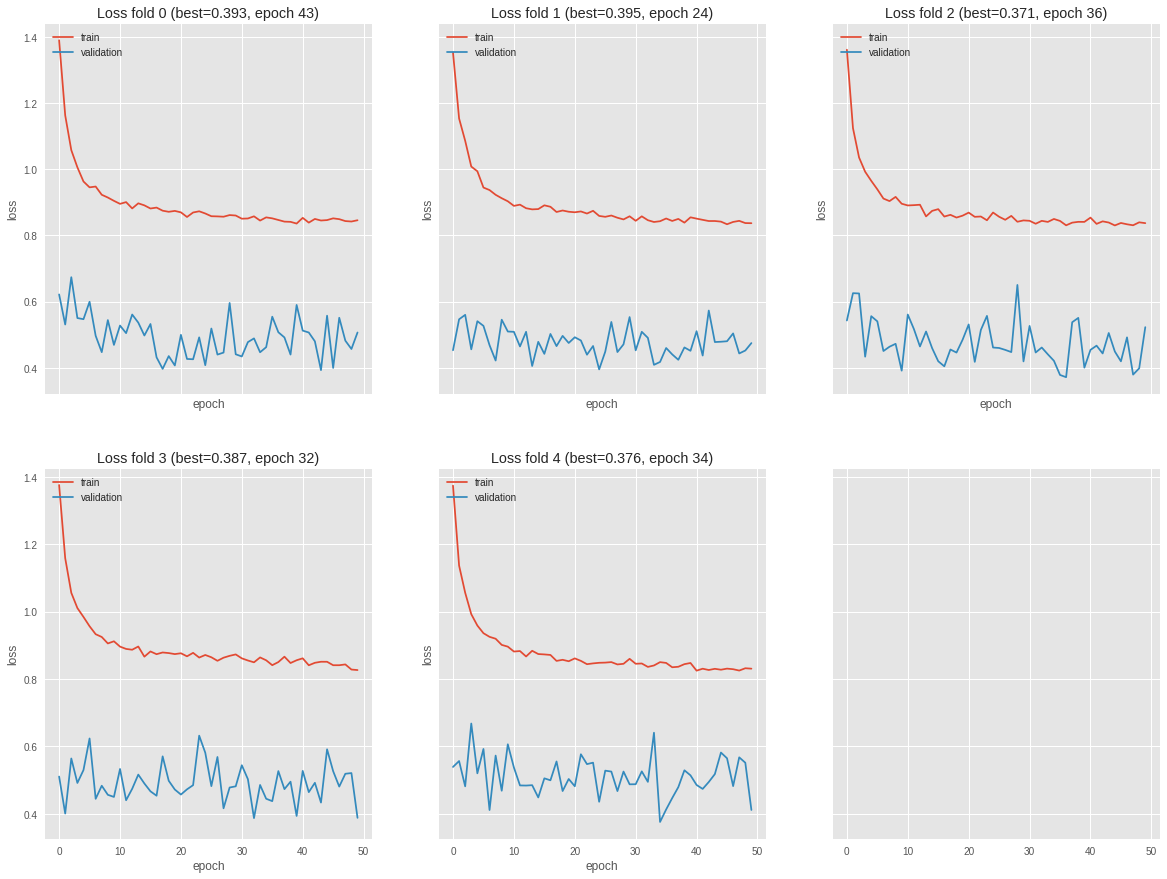

In [16]:

fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(20,15))
for k, history in enumerate(fold_history):
    #Loss
    j = np.argmin(history.history['val_loss'])
    
    ax[int(k // 3), k % 3].plot(history.history['loss'])
    ax[int(k // 3), k % 3].plot(history.history['val_loss'])
    ax[int(k // 3), k % 3].set_title('Loss fold {0} (best={1:.3f}, epoch {2})'.format(k, history.history['val_loss'][j], j))
    ax[int(k // 3), k % 3].set_ylabel('loss')
    ax[int(k // 3), k % 3].set_xlabel('epoch')
    ax[int(k // 3), k % 3].legend(['train', 'validation'], loc='upper left')
plt.savefig('{0}/loss_history.png'.format(folder_name), dpi=500)
plt.show()

Now let's see the performance in both training and test sets:

### Training:

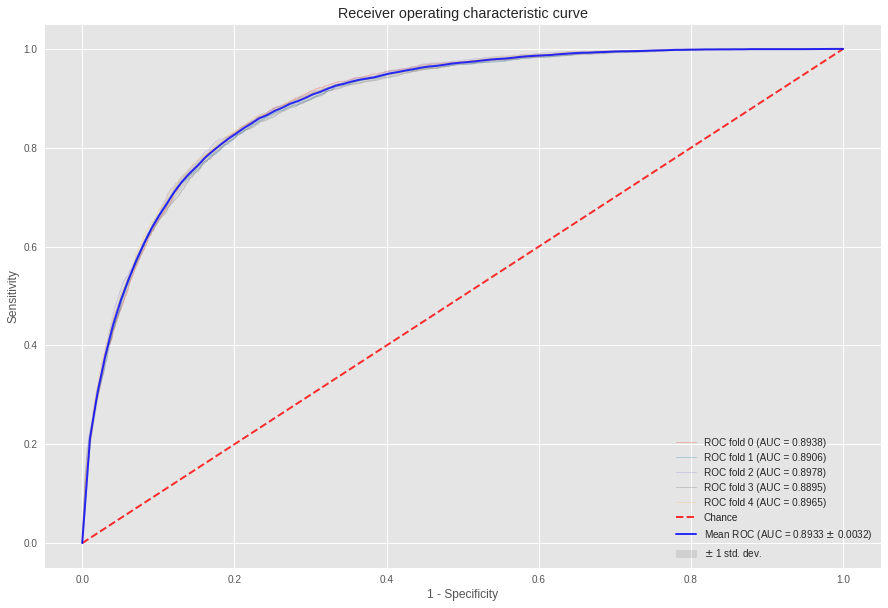

In [17]:
cross_validation_plot_roc_curve(ground_truth_training_set, predictions_training_set,
                               filename='{0}/roc_curve_training.png'.format(folder_name))

### Validation:

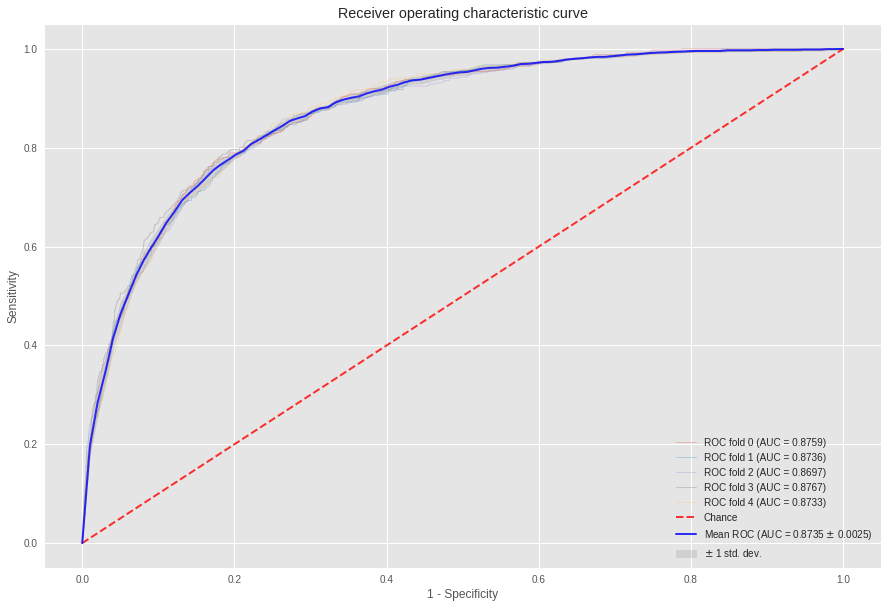

In [18]:
cross_validation_plot_roc_curve(ground_truth, predictions, 
                                filename='{0}/roc_curve_validation.png'.format(folder_name))

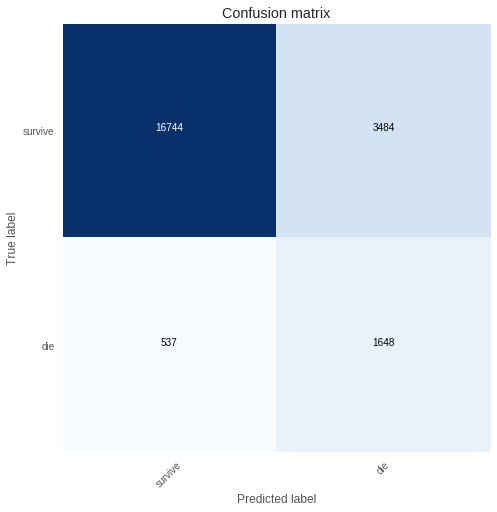

In [19]:
cnf_matrix = [[0,0],[0,0]]
for g,p in zip(ground_truth, predictions):
    #print_classification_report(g, p)
    cnf_matrix += confusion_matrix(g, p.round())
target_names = ['survive', 'die']
plot_confusion_matrix(cnf_matrix, classes=target_names, filename='{0}/confusion_matrix.png'.format(folder_name),
                      title='Confusion matrix')

In [20]:
with open('{0}/model_summary.txt'.format(folder_name),'w') as fh:
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1, 22, 48)    0                                            
__________________________________________________________________________________________________
3h_conv (Conv2D)                (None, 1, 22, 16)    2320        input[0][0]                      
__________________________________________________________________________________________________
6h_conv (Conv2D)                (None, 1, 22, 16)    4624        input[0][0]                      
__________________________________________________________________________________________________
12h_conv (Conv2D)               (None, 1, 22, 16)    9232        input[0][0]                      
__________________________________________________________________________________________________
activation

## Interpretability via Shapley Values and DeepLIFT

In [ ]:
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

import os

import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func

In [ ]:
def visualize_patient_inputs(patient, rows, cols, size, cycle_colors=False, cmap = 'coolwarm', norm=None, colorbar_ticks=[], 
                             feature_importances = None, filename = None):
    
    fig, ax = plt.subplots(rows, cols, sharex='col', figsize=(30,20))
    for i, v in enumerate(predictor_names):
        if v in ('AIDS', 'ELECTIVE', 'METASTATIC_CANCER', 'LYMPHOMA', 'SURGICAL', 'ELECTIVE'):
            ax[int(i // 2), i % 2].set_ylim((-2, 2))
            
        ax[int(i // 2), i % 2].plot(range(48), patient[i],
                   lw=2.5, color=palette(i%10) if cycle_colors else palette(0),
                   marker='o', markersize=6)
        ax[int(i // 2), i % 2].legend([v], loc='upper left')
        if feature_importances is not None:
            if len(feature_importances.shape) == 3:
                for j in range(48):
                    ax[int(i // 2), i % 2].axvspan(j, j+1, facecolor=feature_importances[i,j], alpha=0.5)
            else:
                ax[int(i // 2), i % 2].axvspan(0, 48, facecolor=feature_importances[i], alpha=0.5)
                
    if feature_importances is not None:
        ax_cb = fig.add_axes([0.92,0.125,0.015,0.755])
        cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=norm, ticks=colorbar_ticks, orientation='vertical')
    plt.subplots_adjust(wspace=0.05)
    if filename is not None:
        plt.savefig(filename, dpi=500, bbox_inches='tight')
    plt.show()
    
# set the colormap and centre the colorbar
# http://chris35wills.github.io/matplotlib_diverging_colorbar/
class MidpointNormalize(mpl.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

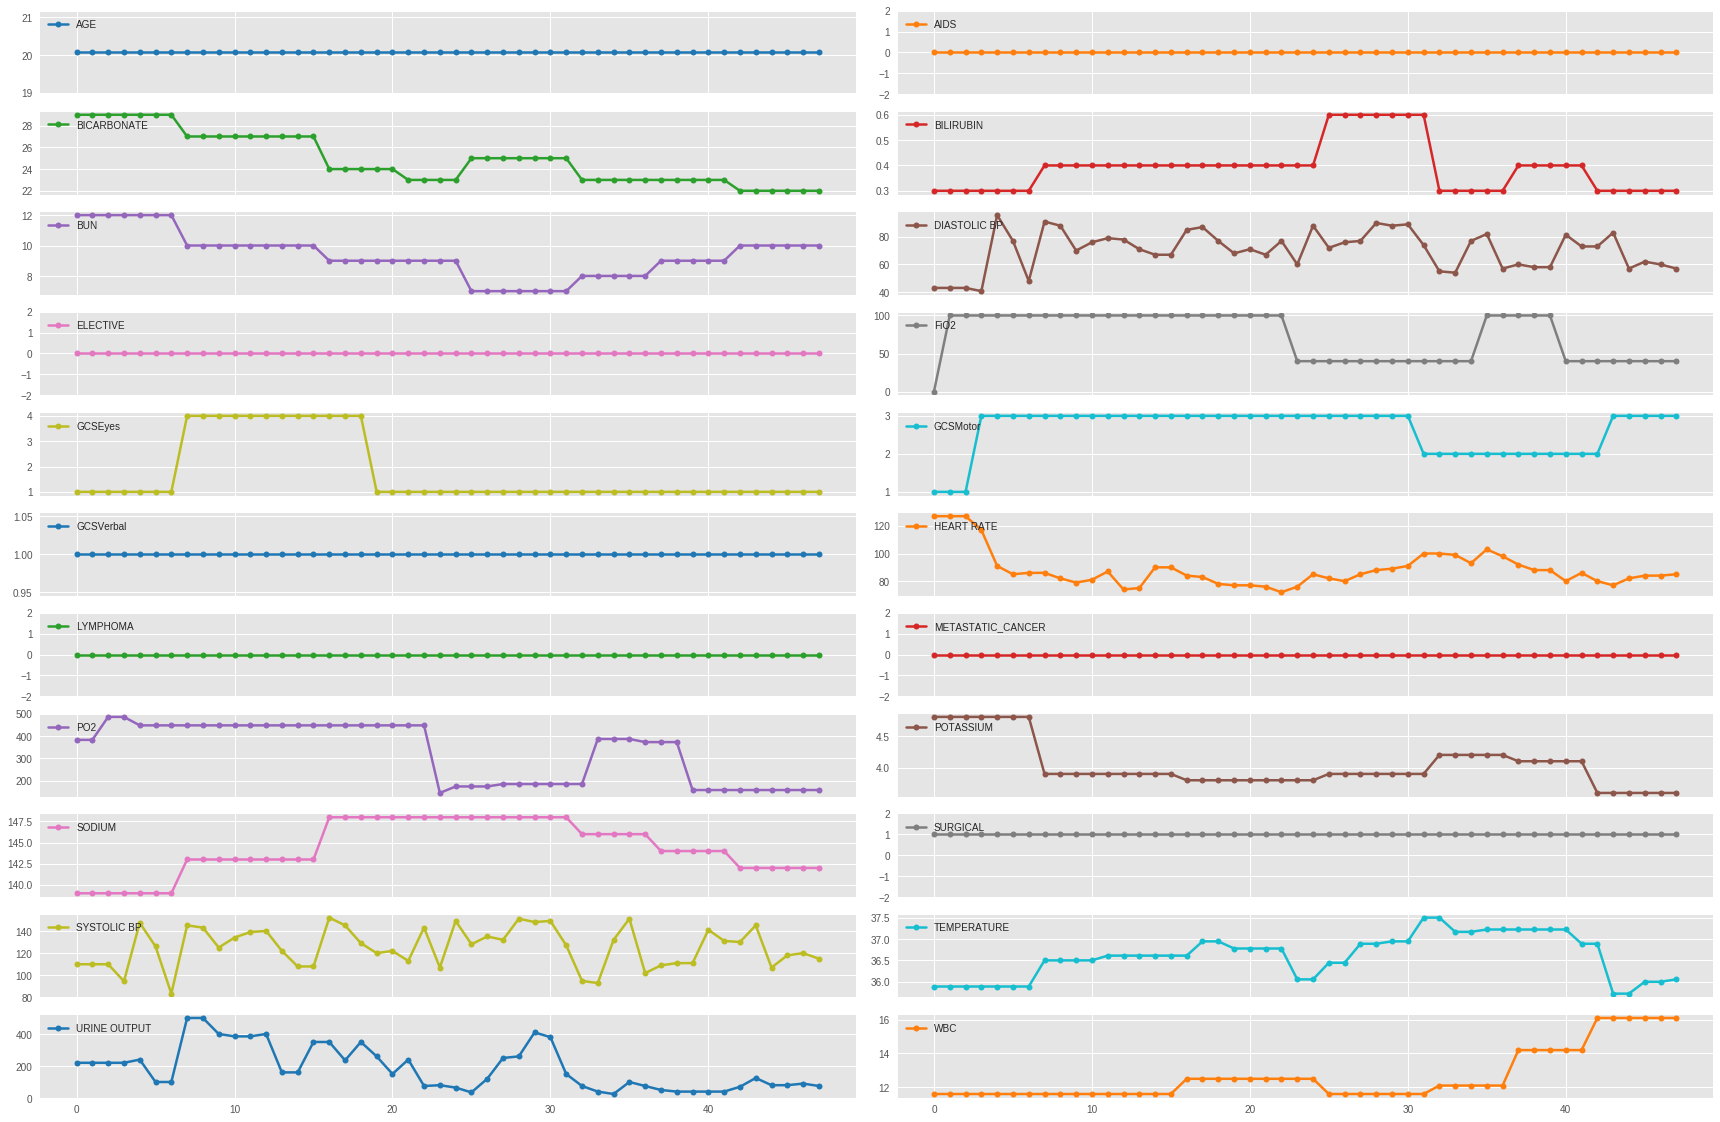

In [23]:
if not os.path.exists('explain_model_plots'):
    os.makedirs('explain_model_plots')
    
validation_idx = cv_idx[4][1]
#Patient belongs to the last fold, an artifact from the time I was using a hold out validation set instead of CV. It's an interesting case becasue the network is on 
# the fence with this one.
patient_index = 1
patient = X[validation_idx[patient_index]][0]
predictor_names = input_dataframe.index.levels[1].values
visualize_patient_inputs(patient, 11, 2, size=(30,20), cycle_colors=True, filename='explain_model_plots/patient{0}_inputs.png'.format(patient_index))

In [24]:
deeplift_model = []
for i in range(5):
  print(f'fold{i}...')
  dm = kc.convert_model_from_saved_files(
      h5_file=f"{folder_name}/kfold{i}_best.hdf5",
                              nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)
  deeplift_model.append(dm)

fold0...
nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
fold1...
nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
fold2...
nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
fold3...
nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
fold4...
nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then

In [ ]:
input_layer_name = deeplift_model[0].get_input_layer_names()[0]
deeplift_prediction_func = []
converted_model_predictions = []
for i in range(5):
  dpf = compile_func([deeplift_model[i].get_name_to_layer()[input_layer_name].get_activation_vars()],
                                           deeplift_model[i].get_name_to_layer()['fc2_0'].get_activation_vars())
  deeplift_prediction_func.append(dpf)

  
  converted_model_predictions += [deeplift.util.run_function_in_batches(
                                  input_data_list=[np.nan_to_num((X[cv_idx[i][1]]- fold_mean[i])/fold_std[i])],
                                  func=deeplift_prediction_func[i],
                                  #batch_size=200,
                                  progress_update=None)]

Done 0
Predicted mortality probability: [0.5764485]
Observed mortality: [1.]


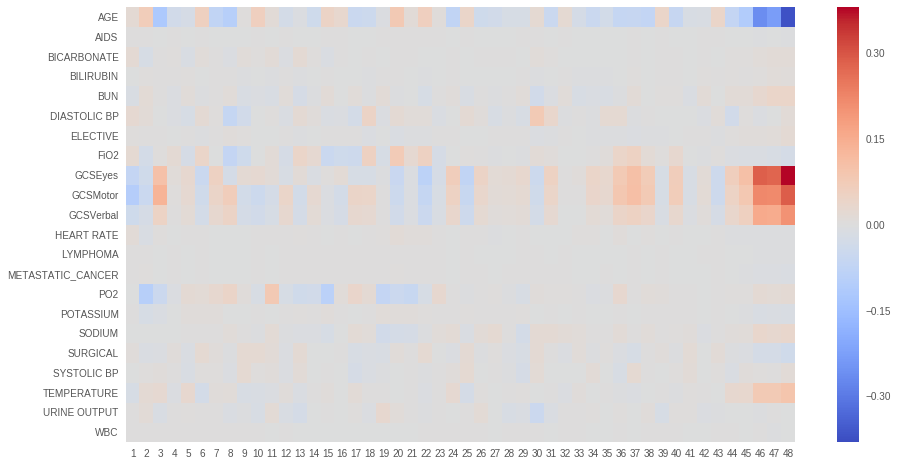

In [26]:
#input_layer_name = deeplift_model.get_input_layer_names()[0]
importance_func = deeplift_model[4].get_target_contribs_func(
    find_scores_layer_name=input_layer_name, pre_activation_target_layer_name='preact_fc2_0')
scores = np.array(
    importance_func(task_idx=0, input_data_list=[[np.nan_to_num((X[validation_idx][patient_index] - fold_mean[4])/fold_std[4])]],
                      input_references_list=[np.zeros_like([X[validation_idx][0]])],
                      batch_size=1,progress_update=1))
print('Predicted mortality probability: {0}'.format(converted_model_predictions[4][patient_index]))
print('Observed mortality: {0}'.format(ground_truth[4][patient_index]))
scores = scores[0][0]
fig, ax = plt.subplots(figsize=(15,8)) 
cmap = 'coolwarm'
#cmap = 'magma'
sns.heatmap(scores, cmap=cmap, center=0, yticklabels = predictor_names, xticklabels = range(1,49))
plt.savefig('explain_model_plots/patient{0}_heatmap.png'.format(patient_index), dpi=500)

In [ ]:
norm = MidpointNormalize(vmin=scores.min(), vmax=scores.max(), midpoint=0)
ticks = np.concatenate((np.linspace(0, scores.min(), 3, endpoint=False), np.linspace(0, scores.max(),3)))
scaled_scores = norm(scores)
heatmap_cm = cm.get_cmap(cmap)

heatmap_colors = heatmap_cm(scaled_scores)

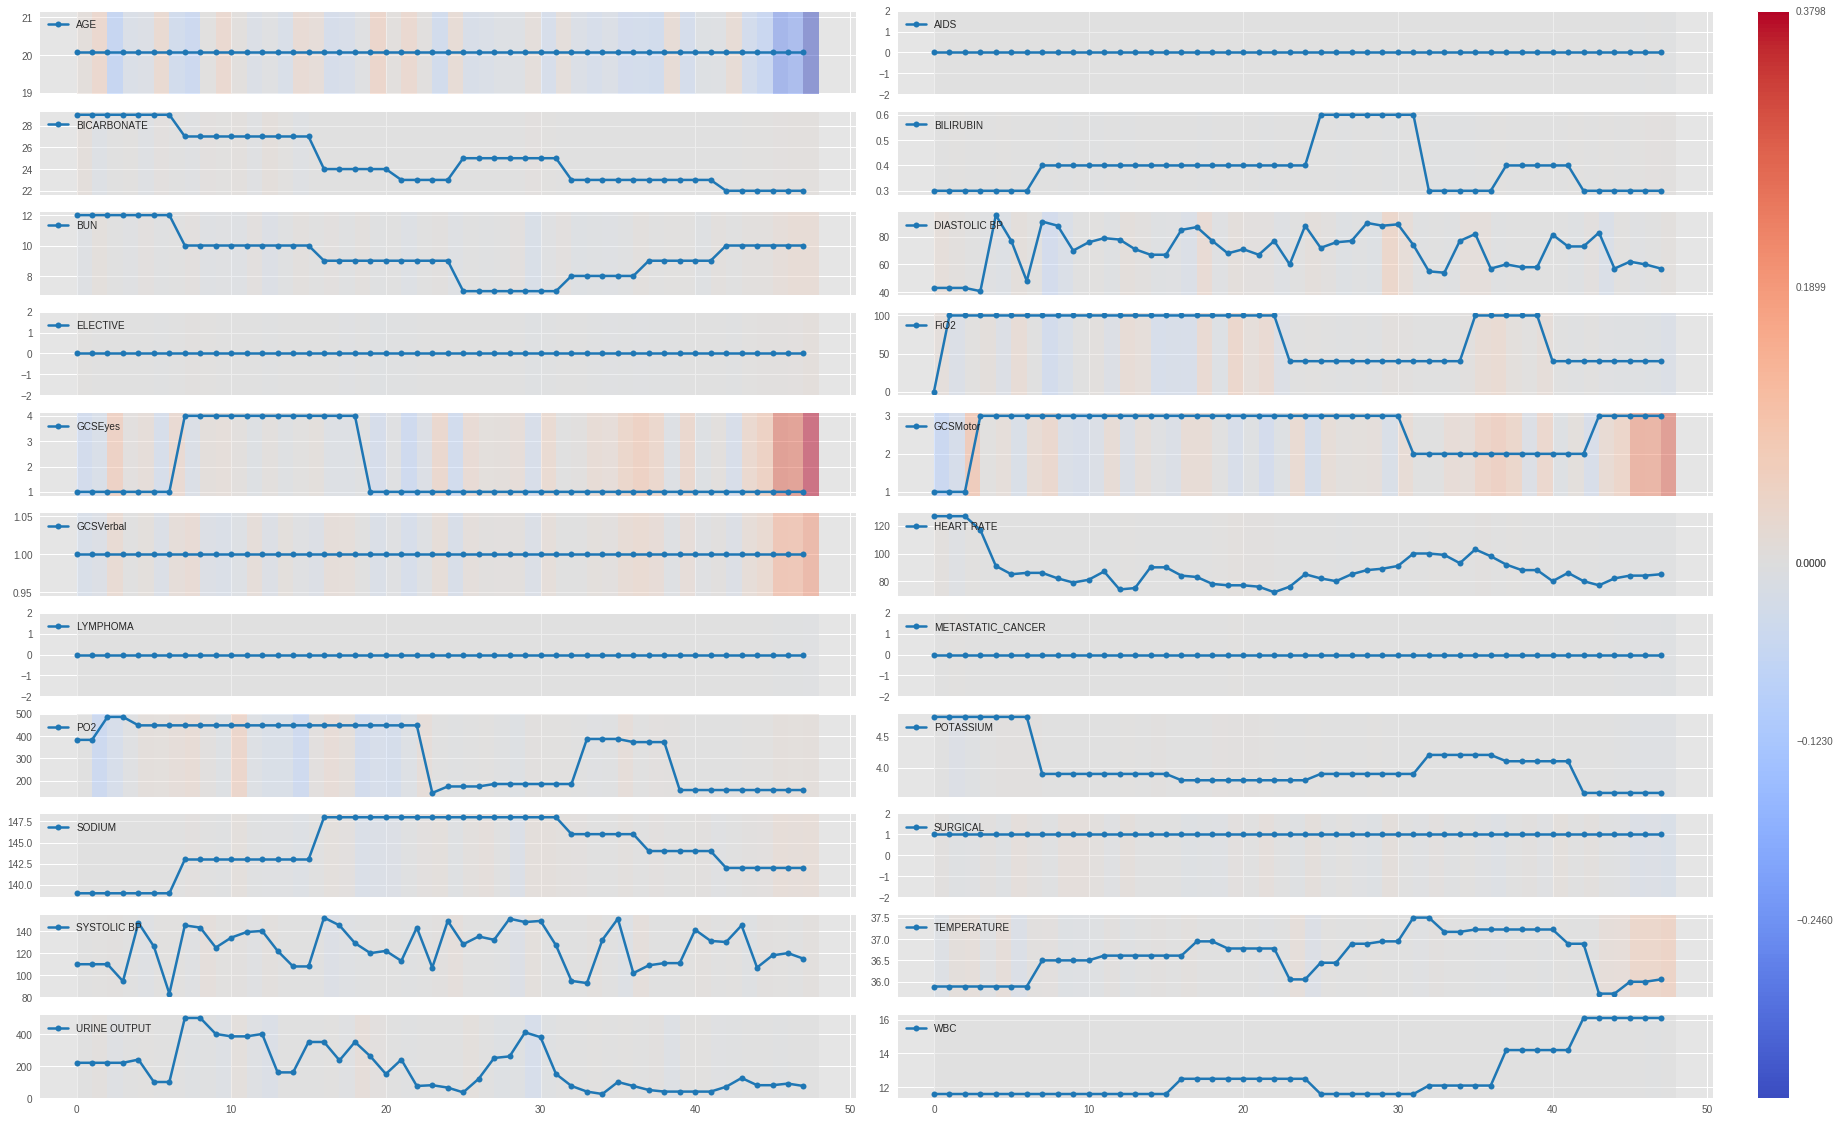

In [28]:
visualize_patient_inputs(patient, 11, 2, size=(30,20), cycle_colors=False, norm=norm, colorbar_ticks=ticks, 
                         feature_importances=heatmap_colors, filename='explain_model_plots/patient{0}_explained_inputs.png'.format(patient_index))

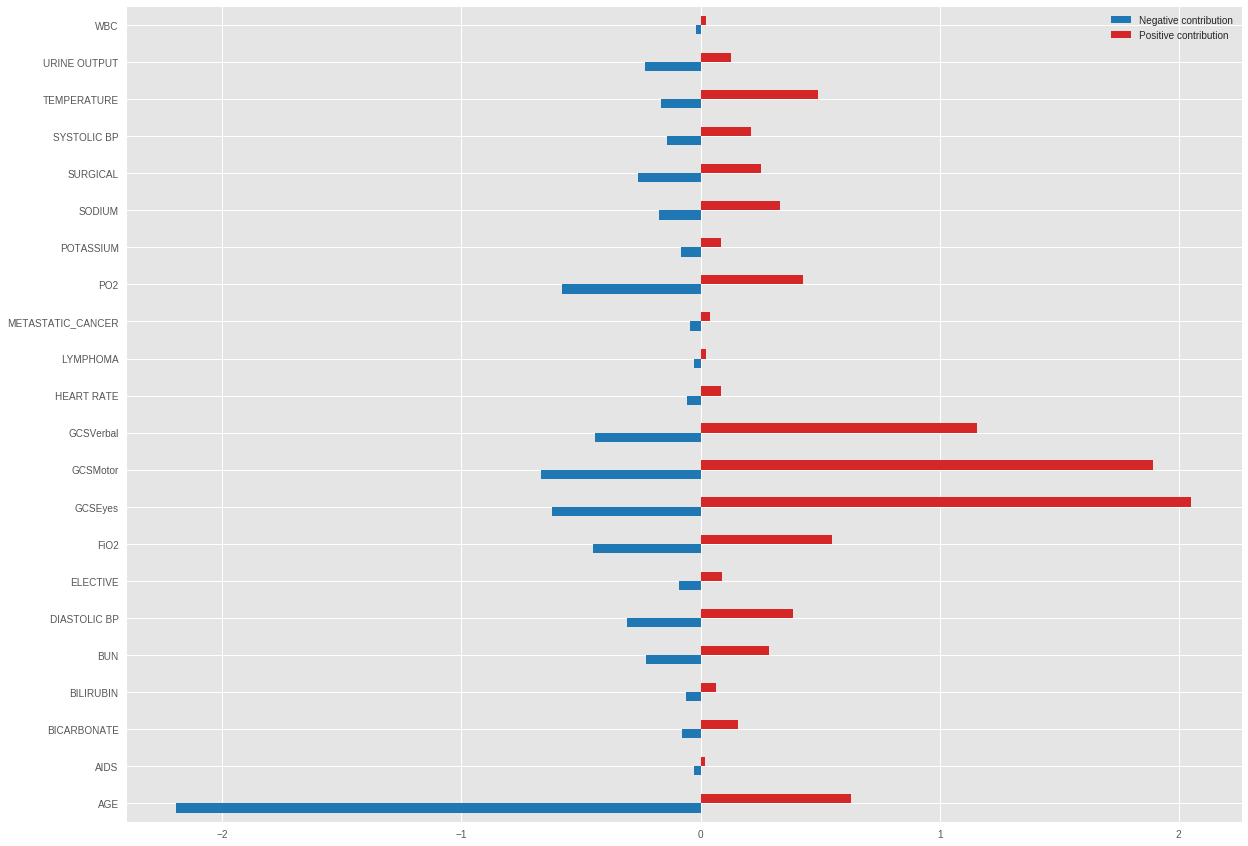

In [29]:
norm = np.sum(np.abs(scores), axis=1)
positive_contribs = np.sum(scores.clip(min=0), axis=1)
negative_contribs = np.sum(scores.clip(max=0), axis=1)
#plt.figure(figsize = (20,10))
df = pd.DataFrame(index=predictor_names,data={'Negative contribution':negative_contribs, 'Positive contribution':positive_contribs})

df.plot.barh(figsize=(20,15), color=[palette(0), palette(3)])
plt.savefig('explain_model_plots/patient{0}_contribs_neg_pos.png'.format(patient_index), dpi=500)

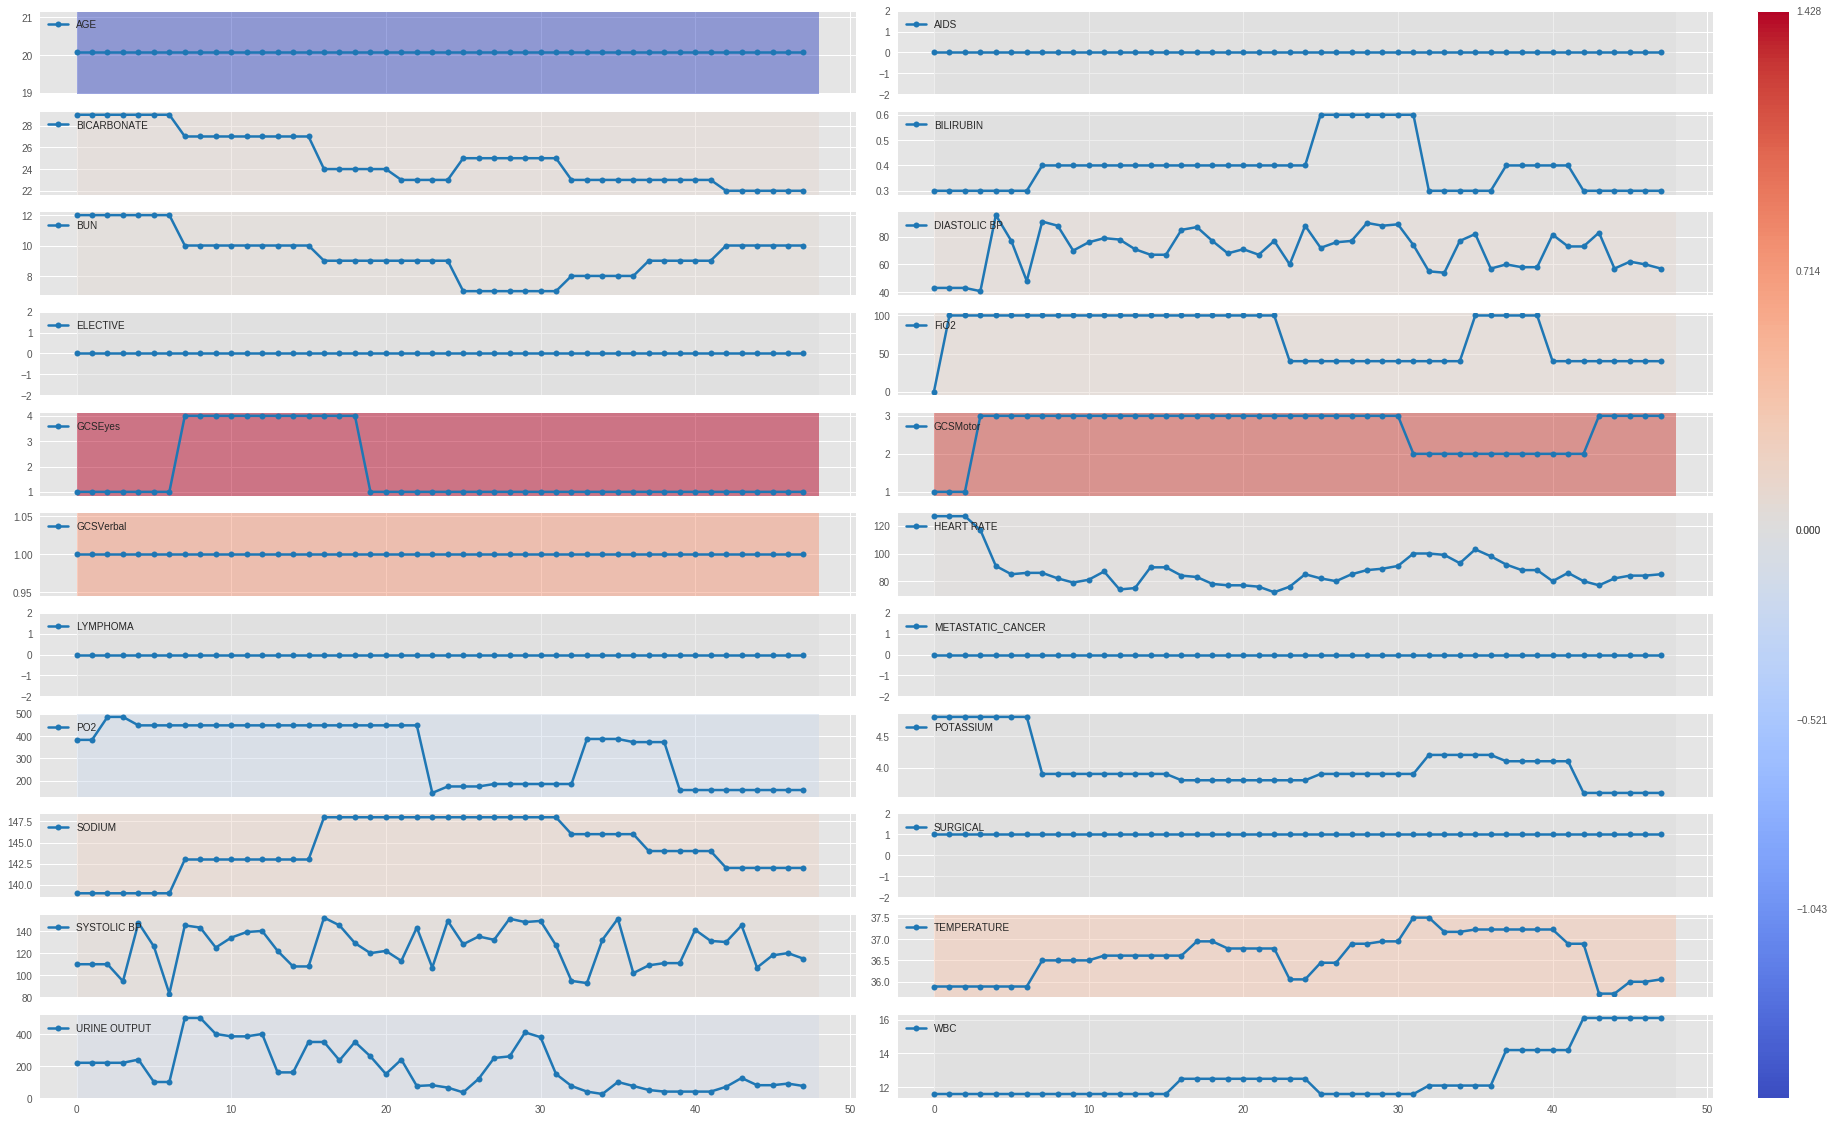

In [30]:
predictor_scores = np.sum(scores, axis=1)
norm = MidpointNormalize(vmin=predictor_scores.min(), vmax=predictor_scores.max(), midpoint=0)
ticks = np.concatenate((np.linspace(0, predictor_scores.min(), 3, endpoint=False), np.linspace(0, predictor_scores.max(),3)))
predictor_scores = norm(predictor_scores)

heatmap_cm = cm.get_cmap(cmap)

heatmap_colors = heatmap_cm(predictor_scores)

visualize_patient_inputs(patient, 11, 2, size=(30,20), cycle_colors=False, norm=norm, colorbar_ticks=ticks, 
                         feature_importances=heatmap_colors, filename='explain_model_plots/patient{0}_explained_predictors.png'.format(patient_index))

In [31]:
all_scores = []
for i in range(5):
  print(f'fold {i}')
  importance_func = deeplift_model[i].get_target_contribs_func(
      find_scores_layer_name=input_layer_name, pre_activation_target_layer_name='preact_fc2_0')
  fold_scores = np.array(
      importance_func(task_idx=0, input_data_list=[np.nan_to_num((X[cv_idx[i][1]]- fold_mean[i])/fold_std[i])],
                        input_references_list=[np.zeros_like(X[cv_idx[i][1]])],
                        batch_size=100,progress_update=None))
  all_scores.append(np.squeeze(fold_scores))

fold 0
fold 1
fold 2
fold 3
fold 4


In [32]:
#all_scores = np.squeeze(all_scores)

all_positive_predictor_scores = []
all_negative_predictor_scores = []
real_outcome = []

for fold_scores, fold_ground_truth in zip(all_scores, ground_truth):
  print(f'number of NaN scores: {np.isnan(fold_scores).sum()/48.}')
  positive_sums = np.sum(fold_scores.clip(min=0), axis=2)
  negative_sums = np.sum(fold_scores.clip(max=0), axis=2)
  for i in range(fold_scores.shape[0]):
    if True:#not np.any(np.isnan(positive_sums[i])) and not np.any(np.isnan(negative_sums[i])):
      all_positive_predictor_scores.append(positive_sums[i]/np.sum(positive_sums[i]))
      all_negative_predictor_scores.append(negative_sums[i]/-np.sum(negative_sums[i]))
      real_outcome.append([fold_ground_truth[i]]*22)
    
all_positive_predictor_scores = np.array(all_positive_predictor_scores).flatten()
all_negative_predictor_scores = np.array(all_negative_predictor_scores).flatten()
all_predictor_names = np.tile(predictor_names,int(all_positive_predictor_scores.shape[0]/22))
real_outcome = np.array(real_outcome).flatten()

df = pd.DataFrame({'Predictors':all_predictor_names,'Positive Importance Score':all_positive_predictor_scores,
                   'Negative Importance Score':all_negative_predictor_scores, 'Real Outcome':real_outcome})

number of NaN scores: 0.0
number of NaN scores: 0.0
number of NaN scores: 0.0
number of NaN scores: 0.0
number of NaN scores: 0.0


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


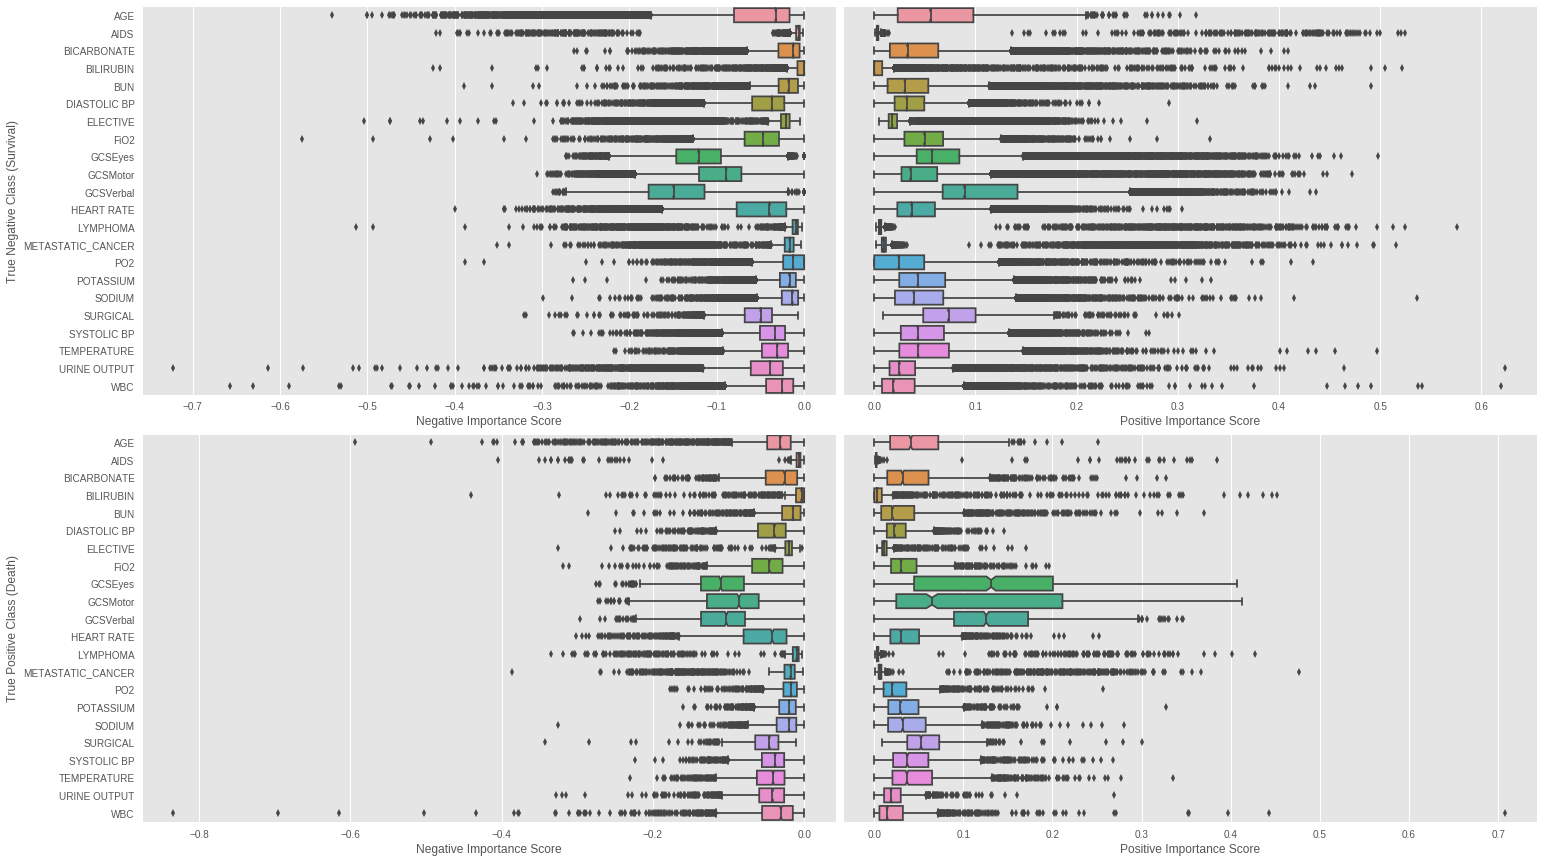

In [36]:
#plt.figure(figsize=(15,10))
fig, ax = plt.subplots(2, 2, sharey='row', figsize=(25,15))
sns.boxplot( y= "Predictors", x="Negative Importance Score", data=df[df['Real Outcome'] == 0].drop('Real Outcome', axis= 1), notch=True, ax=ax[0,0])
sns.boxplot( y= "Predictors", x="Positive Importance Score", data=df[df['Real Outcome'] == 0].drop('Real Outcome', axis = 1), notch=True, ax=ax[0,1])
sns.boxplot( y= "Predictors", x="Negative Importance Score", data=df[df['Real Outcome'] == 1].drop('Real Outcome', axis= 1), notch=True, ax=ax[1,0])
sns.boxplot( y= "Predictors", x="Positive Importance Score", data=df[df['Real Outcome'] == 1].drop('Real Outcome', axis = 1), notch=True, ax=ax[1,1])
plt.subplots_adjust(wspace=0.01)
plt.subplots_adjust(hspace=0.1)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[0,0].set_ylabel('True Negative Class (Survival)')
ax[1,0].set_ylabel('True Positive Class (Death)')

plt.savefig('explain_model_plots/dataset_contribs_neg_pos.png', dpi=500)

In [34]:
#fig, ax = plt.subplots()
grouped = df.groupby('Predictors')
#grouped.median().plot.barh(figsize=(20,15), xerr=grouped.std(), color=[palette(0), palette(3)], ax=ax)
#plt.savefig('explain_model_plots/dataset_contribs_neg_pos.png'.format(patient_index), dpi=500)
grouped.describe()

Negative Importance Score                                \
                                      count      mean       std       min   
Predictors                                                                  
AGE                                 22413.0 -0.065056  0.081053 -0.593109   
AIDS                                22413.0 -0.010033  0.027732 -0.421643   
BICARBONATE                         22413.0 -0.023283  0.026363 -0.263493   
BILIRUBIN                           22413.0 -0.005422  0.015717 -0.439834   
BUN                                 22413.0 -0.022046  0.022686 -0.389074   
DIASTOLIC BP                        22413.0 -0.046208  0.033331 -0.332920   
ELECTIVE                            22413.0 -0.040278  0.052108 -0.504012   
FiO2                                22413.0 -0.052270  0.032575 -0.575152   
GCSEyes                             22413.0 -0.119546  0.041214 -0.275154   
GCSMotor                            22413.0 -0.100343  0.047683 -0.305781   
GCSVerbal                           22413.0 -0.142177  0.045934 -0.295857   
HEART RATE                          22413.0 -0.057254  0.051243 -0.399899   
LYMPHOMA                            22413.0 -0.015949  0.033135 -0.512698   
METASTATIC_CANCER                   22413.0 -0.025453  0.034408 -0.386188   
PO2                                 22413.0 -0.017278  0.020744 -0.388273   
POTASSIUM                           22413.0 -0.021640  0.017856 -0.264093   
SODIUM                              22413.0 -0.020372  0.020610 -0.325851   
SURGICAL                            22413.0 -0.053813  0.023026 -0.343082   
SYSTOLIC BP                         22413.0 -0.040541  0.027326 -0.264610   
TEMPERATURE                         22413.0 -0.037635  0.026486 -0.229682   
URINE OUTPUT                        22413.0 -0.049333  0.040805 -0.722297   
WBC                                 22413.0 -0.034069  0.035946 -0.833889   

                                                               \
                        25%       50%       75%           max   
Predictors                                                      
AGE               -0.076357 -0.032372 -0.016831 -4.707347e-07   
AIDS              -0.009339 -0.006464 -0.005000 -6.603467e-04   
BICARBONATE       -0.032028 -0.013337 -0.005436  0.000000e+00   
BILIRUBIN         -0.008135  0.000000  0.000000  0.000000e+00   
BUN               -0.029281 -0.017586 -0.006827  0.000000e+00   
DIASTOLIC BP      -0.059791 -0.037263 -0.022917  0.000000e+00   
ELECTIVE          -0.026363 -0.020798 -0.016535 -2.486274e-03   
FiO2              -0.068284 -0.046967 -0.028791 -7.098037e-06   
GCSEyes           -0.145699 -0.119822 -0.093863  0.000000e+00   
GCSMotor          -0.121250 -0.089160 -0.071018  0.000000e+00   
GCSVerbal         -0.175893 -0.145745 -0.108359  0.000000e+00   
HEART RATE        -0.077527 -0.040039 -0.020687  0.000000e+00   
LYMPHOMA          -0.013454 -0.009608 -0.007164 -2.331961e-03   
METASTATIC_CANCER -0.022655 -0.016675 -0.012044 -1.836194e-03   
PO2               -0.024418 -0.013177  0.000000  0.000000e+00   
POTASSIUM         -0.028296 -0.017075 -0.009676  0.000000e+00   
SODIUM            -0.026600 -0.014028 -0.007119  0.000000e+00   
SURGICAL          -0.067770 -0.049376 -0.036542 -7.589592e-03   
SYSTOLIC BP       -0.051286 -0.033890 -0.022231  0.000000e+00   
TEMPERATURE       -0.049838 -0.031673 -0.018990  0.000000e+00   
URINE OUTPUT      -0.060897 -0.039334 -0.024551  0.000000e+00   
WBC               -0.044662 -0.025671 -0.012690  0.000000e+00   

                  Positive Importance Score           ...             \
                                      count      mean ...        75%   
Predictors                                            ...              
AGE                                 22413.0  0.062653 ...   0.095723   
AIDS                                22413.0  0.006785 ...   0.003990   
BICARBONATE                         22413.0  0.046442 ...   0.063059   
BILIRUBIN                         